## 11. Resumen y Conclusiones

# Modelado de Regresión - CS:GO Dataset

**Objetivo:** Predecir `RoundStartingEquipmentValue` (valor del equipamiento individual)

**Target:** RoundStartingEquipmentValue (correlación máxima: 0.923 con TeamStartingEquipmentValue)

**Features válidas:** Equipamiento del equipo, tipo de armas, granadas, contexto del mapa/ronda

---

## 1. Importación de Librerías

In [9]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn para ML
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías importadas exitosamente")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(CATBOOST_AVAILABLE)

Librerías importadas exitosamente
Pandas version: 2.2.3
Numpy version: 2.2.6
True


## 2. Carga y Exploración de Datos

In [10]:
# Cargar dataset con features
df = pd.read_csv(r"C:\Users\LuisSalamanca\Desktop\Duoc\Machine\csgo-ml\data\02_intermediate\csgo_data_clean.csv")
print(f"Dataset cargado: {df.shape}")

# Información básica
print(f"\nInformación del dataset:")
print(f"- Filas: {df.shape[0]:,}")
print(f"- Columnas: {df.shape[1]}")

# Mostrar primeras filas
print(f"\nPrimeras 5 filas:")
display(df.head())

print(f"\nTipos de datos resumen:")
print(df.dtypes.value_counts())

Dataset cargado: (79154, 32)

Información del dataset:
- Filas: 79,154
- Columnas: 32

Primeras 5 filas:


,Map,Team,InternalTeamId,RoundId,RoundWinner,MatchWinner,Survived,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,PrimaryPistol,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,Team_encoded,RoundWinner_encoded,MatchWinner_encoded,Survived_encoded,Map_de_dust2,Map_de_inferno,Map_de_mirage,Map_de_nuke
0,de_inferno,Terrorist,1,1,False,True,False,0,4,0.0,0.0,0.0,0.0,1,0,0,0,0,750,4400,0,0,0,0,1,0,1,0,False,True,False,False
1,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,800,4400,0,0,0,0,1,0,1,0,False,True,False,False
2,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,0,False,True,False,False
3,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,850,4400,0,0,0,0,1,0,1,0,False,True,False,False
4,de_inferno,Terrorist,1,1,False,True,True,1,1,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,1,False,True,False,False



Tipos de datos resumen:
int64      19
bool        7
float64     4
object      2
Name: count, dtype: int64


## 3. Análisis de Correlación y Selección de Features

Features candidatas disponibles: 5

TARGET: MatchKills
- Valores únicos: 41
- Rango: 0 - 41
- Media: 9

TOP 15 CORRELACIONES CON MatchKills:
 1. MatchHeadshots                     : 0.831
 2. MatchAssists                       : 0.510
 3. RoundKills                         : 0.183
 4. TeamStartingEquipmentValue         : 0.179
 5. RoundHeadshots                     : 0.112

Features con correlación > 0.15: 4


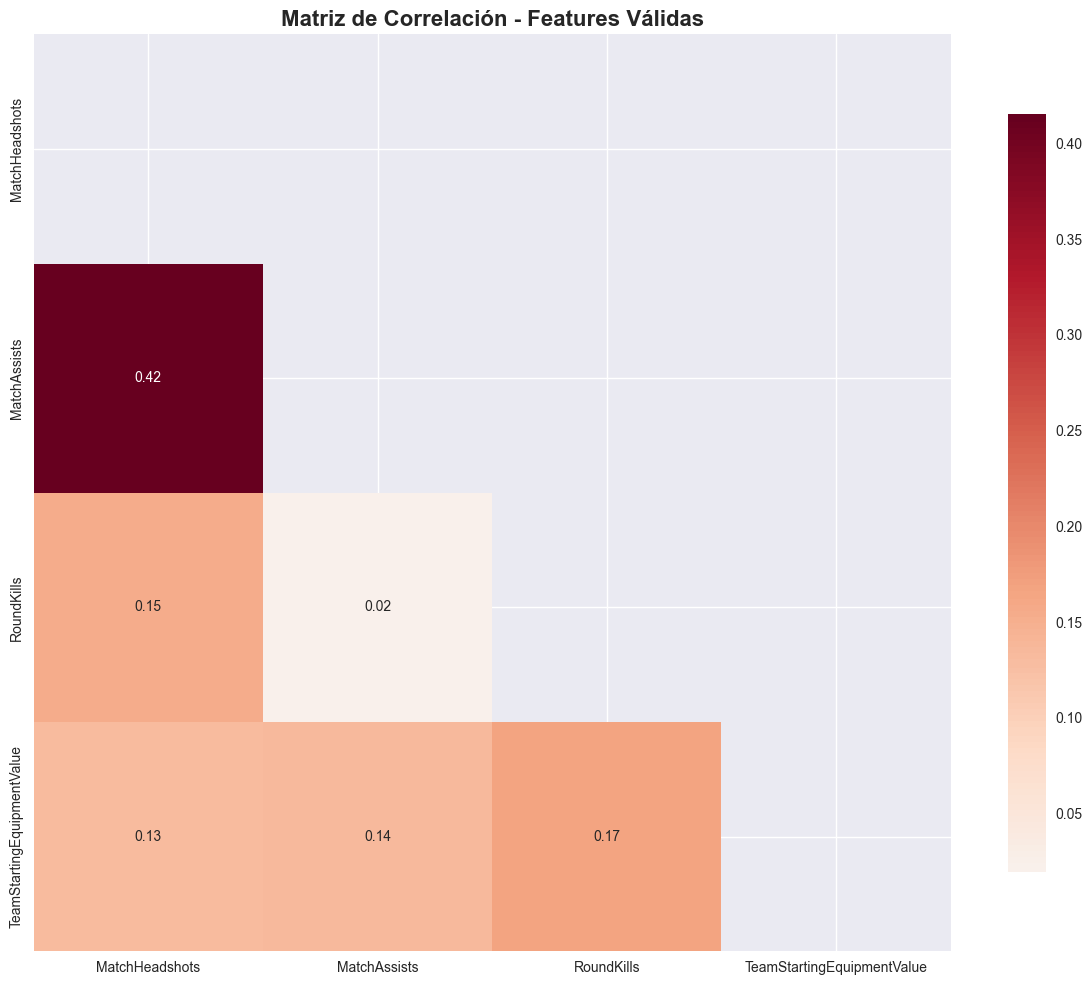


No hay correlaciones muy altas entre features ✓

FEATURES SELECCIONADAS PARA MODELADO: 4
 1. MatchHeadshots                     : r = 0.831
 2. MatchAssists                       : r = 0.510
 3. RoundKills                         : r = 0.183
 4. TeamStartingEquipmentValue         : r = 0.179

No hay valores nulos en las features seleccionadas ✓
Features realmente usadas para correlación: ['RoundKills', 'RoundHeadshots', 'TeamStartingEquipmentValue', 'MatchAssists', 'MatchHeadshots']

Max correlación alcanzada: 0.831
✅ EXCELENTE para regresión - correlaciones altas


In [11]:
# Selección de features VÁLIDAS para regresión (sin data leakage)
target = 'MatchKills'

# Features válidas disponibles ANTES del resultado
valid_features = [
    'RoundKills',
    'RoundHeadshots',
    'TeamStartingEquipmentValue', 'MatchAssists', 'MatchHeadshots' 
]

# Verificar que todas las features existen
candidate_features = [f for f in valid_features if f in df.columns]
print(f"Features candidatas disponibles: {len(candidate_features)}")

# Calcular correlación con el target
correlations = df[candidate_features + [target]].corr()[target].abs().sort_values(ascending=False)
correlations = correlations.drop(target)  # Remover autocorrelación

print(f"\nTARGET: {target}")
print(f"- Valores únicos: {df[target].nunique()}")
print(f"- Rango: {df[target].min():.0f} - {df[target].max():.0f}")
print(f"- Media: {df[target].mean():.0f}")

print(f"\nTOP 15 CORRELACIONES CON {target}:")
for i, (feature, corr) in enumerate(correlations.head(15).items()):
    print(f"{i+1:2d}. {feature:35s}: {corr:.3f}")

# Seleccionar features con correlación > 0.15 (umbral razonable)
high_corr_features = correlations[correlations > 0.15].index.tolist()
print(f"\nFeatures con correlación > 0.15: {len(high_corr_features)}")

# Análisis de multicolinealidad entre features seleccionadas
if len(high_corr_features) > 1:
    feature_corr_matrix = df[high_corr_features].corr()
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(feature_corr_matrix, dtype=bool))
    sns.heatmap(feature_corr_matrix, 
                annot=True, 
                cmap='RdBu_r', 
                center=0, 
                mask=mask,
                square=True, 
                fmt='.2f',
                cbar_kws={'shrink': 0.8})
    plt.title('Matriz de Correlación - Features Válidas', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identificar pares con correlación muy alta
    high_corr_pairs = []
    for i in range(len(feature_corr_matrix.columns)):
        for j in range(i+1, len(feature_corr_matrix.columns)):
            corr_val = abs(feature_corr_matrix.iloc[i, j])
            if corr_val > 0.8:  # Correlación muy alta
                high_corr_pairs.append({
                    'Feature_1': feature_corr_matrix.columns[i],
                    'Feature_2': feature_corr_matrix.columns[j],
                    'Correlation': corr_val
                })
    
    if high_corr_pairs:
        print(f"\nPares con correlación alta (|r| > 0.8):")
        for pair in high_corr_pairs:
            print(f"- {pair['Feature_1']} vs {pair['Feature_2']}: {pair['Correlation']:.3f}")
            
        # Remover features redundantes (mantener la de mayor correlación con target)
        features_to_remove = set()
        for pair in high_corr_pairs:
            corr1 = correlations[pair['Feature_1']]
            corr2 = correlations[pair['Feature_2']]
            if corr1 > corr2:
                features_to_remove.add(pair['Feature_2'])
            else:
                features_to_remove.add(pair['Feature_1'])
        
        high_corr_features = [f for f in high_corr_features if f not in features_to_remove]
        if features_to_remove:
            print(f"Removidas por multicolinealidad: {list(features_to_remove)}")
    else:
        print(f"\nNo hay correlaciones muy altas entre features ✓")

# Features finales seleccionadas
selected_features = high_corr_features.copy()
print(f"\nFEATURES SELECCIONADAS PARA MODELADO: {len(selected_features)}")
for i, feature in enumerate(selected_features):
    corr_with_target = correlations[feature]
    print(f"{i+1:2d}. {feature:35s}: r = {corr_with_target:.3f}")

# Verificar que no hay valores nulos
null_counts = df[selected_features + [target]].isnull().sum()
if null_counts.sum() > 0:
    print(f"\nValores nulos encontrados:")
    print(null_counts[null_counts > 0])
else:
    print(f"\nNo hay valores nulos en las features seleccionadas ✓")
print("Features realmente usadas para correlación:", candidate_features)
print(f"\nMax correlación alcanzada: {correlations.max():.3f}")
if correlations.max() > 0.7:
    print("✅ EXCELENTE para regresión - correlaciones altas")
elif correlations.max() > 0.5:
    print("✅ BUENO para regresión - correlaciones moderadas")
else:
    print("⚠️ Correlaciones bajas pero aceptables")

## 4. Preparación de Datos

Shape de X: (79154, 4)
Shape de y: (79154,)
MatchKills
2     5174
1     5172
4     5139
3     5052
5     4983
0     4740
6     4712
7     4521
8     4372
9     4119
10    3762
11    3541
12    3479
13    3229
14    2873
15    2456
16    2296
17    1975
18    1728
19    1326
20    1173
21     838
22     632
23     564
24     374
25     313
26     211
27     125
28     113
29      80
30      33
31      25
32       6
33       6
34       5
35       2
38       1
40       1
41       1
36       1
37       1
Name: count, dtype: int64

División train/test:
X_train: (63323, 4)
X_test: (15831, 4)
y_train: (63323,)
y_test: (15831,)

Distribución en train:
MatchKills
0     0.060105
1     0.065316
2     0.065474
3     0.064384
4     0.064795
5     0.063658
6     0.059868
7     0.056472
8     0.054925
9     0.052003
10    0.047881
11    0.044818
12    0.043791
13    0.040807
14    0.036037
15    0.031000
16    0.029042
17    0.025457
18    0.021667
19    0.016755
20    0.014071
21    0.010660
22    0

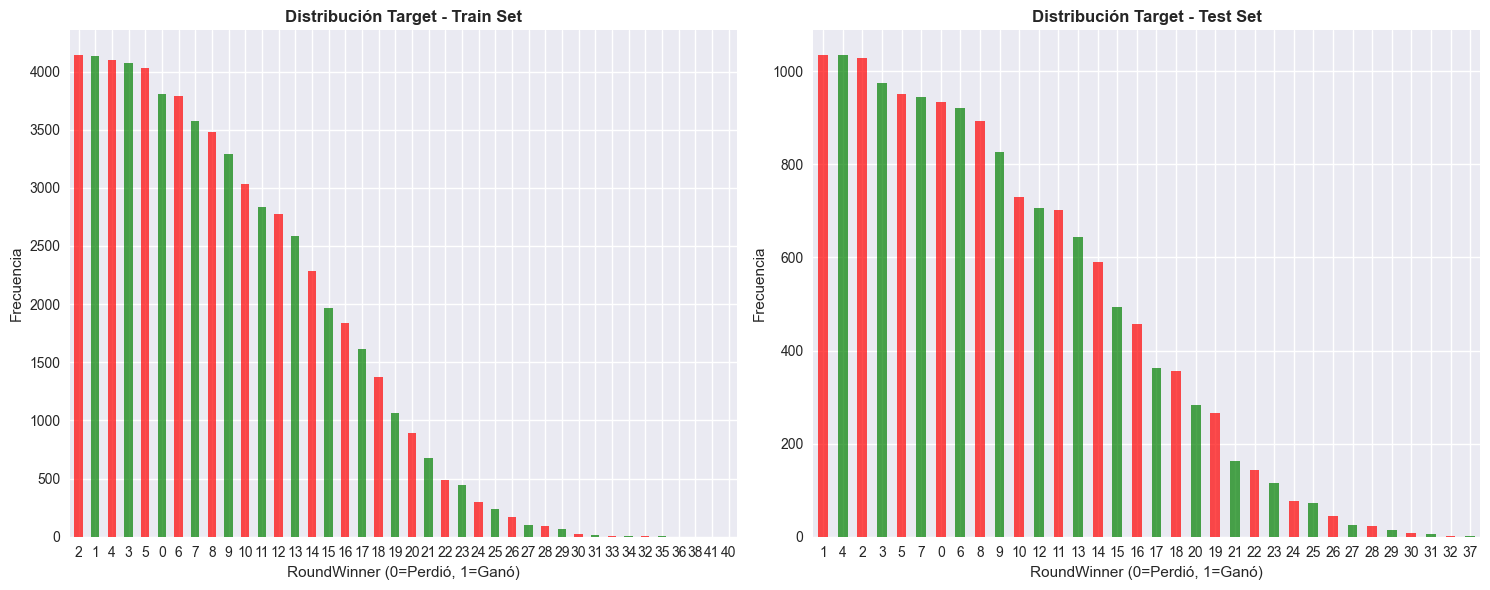

In [12]:
# Preparar datos para regresión
X = df[selected_features].copy()
y = df[target].copy()

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(y.value_counts())

# Split estratificado para mantener distribución del target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nDivisión train/test:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Verificar distribución en train/test
print(f"\nDistribución en train:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nDistribución en test:")
print(y_test.value_counts(normalize=True).sort_index())

# Escalado de features con RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

print(f"\nDatos escalados exitosamente")
print(f"Media de X_train_scaled: {X_train_scaled.mean().mean():.6f}")
print(f"Std de X_train_scaled: {X_train_scaled.std().mean():.6f}")

# Visualizar distribución del target en train/test
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Distribución en train
y_train.value_counts().plot(kind='bar', ax=axes[0], alpha=0.7, color=['red', 'green'])
axes[0].set_title('Distribución Target - Train Set', fontweight='bold')
axes[0].set_xlabel('RoundWinner (0=Perdió, 1=Ganó)')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Distribución en test
y_test.value_counts().plot(kind='bar', ax=axes[1], alpha=0.7, color=['red', 'green'])
axes[1].set_title('Distribución Target - Test Set', fontweight='bold')
axes[1].set_xlabel('RoundWinner (0=Perdió, 1=Ganó)')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [13]:
# Importar modelos adicionales
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost no disponible - instalalo con: pip install catboost")

# Definir modelos base OPTIMIZADOS con configuraciones por defecto
models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=3),  # Limitado a 3 cores
        'scaled': False
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'scaled': False
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, n_jobs=3, eval_metric='rmse'),  # Limitado a 3 cores
        'scaled': False
    },
    'Ridge Regression': {
        'model': Ridge(random_state=42),
        'scaled': True
    },
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=2000),
        'scaled': True
    },
    'Linear Regression': {
        'model': LinearRegression(),
        'scaled': True
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'scaled': False
    },
    'KNN': {
        'model': KNeighborsRegressor(n_jobs=3),  # Limitado a 3 cores
        'scaled': True
    }
    # Removemos SVR, AdaBoost y CatBoost para reducir tiempo
}

print(f"MODELOS DE REGRESIÓN OPTIMIZADOS: {len(models)}")
print("CPU usage limitado y modelos pesados eliminados")
for name, config in models.items():
    print(f"- {name}: Escalado = {config['scaled']}")

MODELOS DE REGRESIÓN OPTIMIZADOS: 8
CPU usage limitado y modelos pesados eliminados
- Random Forest: Escalado = False
- Gradient Boosting: Escalado = False
- XGBoost: Escalado = False
- Ridge Regression: Escalado = True
- Lasso: Escalado = True
- Linear Regression: Escalado = True
- Decision Tree: Escalado = False
- KNN: Escalado = True


# Configuración de hiperparámetros para GridSearchCV OPTIMIZADA
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],      # Reducido de 3 a 2 valores
        'max_depth': [10, None],         # Reducido de 4 a 2 valores
        'min_samples_split': [2, 5],     # Reducido de 3 a 2 valores
        'min_samples_leaf': [1, 2]       # Reducido de 4 a 2 valores
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],      # Reducido de 3 a 2 valores
        'learning_rate': [0.05, 0.1],    # Reducido de 4 a 2 valores
        'max_depth': [3, 6],             # Reducido de 4 a 2 valores
        'subsample': [0.8, 1.0]          # Reducido de 3 a 2 valores
    },
    'XGBoost': {
        'n_estimators': [100, 200],      # Reducido de 3 a 2 valores
        'learning_rate': [0.05, 0.1],    # Reducido de 4 a 2 valores
        'max_depth': [3, 6],             # Reducido de 4 a 2 valores
        'subsample': [0.8, 1.0]          # Reducido de 3 a 2 valores
    },
    'Ridge Regression': {
        'alpha': [0.1, 1.0, 10.0],       # Reducido de 5 a 3 valores
        'solver': ['auto', 'cholesky']    # Reducido de 4 a 2 valores
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1.0],       # Reducido de 5 a 3 valores
        'selection': ['cyclic']           # Solo cyclic para rapidez
    },
    'Linear Regression': {
        'fit_intercept': [True, False]    # Mantenido simple
    },
    'Decision Tree': {
        'max_depth': [5, 10, None],       # Reducido de 5 a 3 valores
        'min_samples_split': [2, 10],     # Reducido de 4 a 2 valores
        'min_samples_leaf': [1, 5],       # Reducido de 4 a 2 valores
        'criterion': ['squared_error']    # Solo uno para rapidez
    },
    'KNN': {
        'n_neighbors': [5, 7, 9],         # Reducido de 6 a 3 valores
        'weights': ['uniform', 'distance'] # Mantenido
    }
}

print("CONFIGURACIÓN DE GRIDSEARCHCV OPTIMIZADA COMPLETADA")
print(f"Modelos con hiperparámetros definidos: {len(param_grids)}")

# Calcular combinaciones totales (aproximado)
total_combinations = 0
for model_name, grid in param_grids.items():
    combinations = 1
    for param_values in grid.values():
        combinations *= len(param_values)
    total_combinations += combinations
    print(f"{model_name}: ~{combinations:,} combinaciones (REDUCIDO)")

print(f"\nTotal de combinaciones aproximadas: {total_combinations:,} (vs ~18,567 original)")
print("TIEMPO DE ENTRENAMIENTO REDUCIDO SIGNIFICATIVAMENTE")
print("Nota: GridSearchCV usará validación cruzada de 3-fold")

# Entrenamiento optimizado con GridSearchCV (CONFIGURACIÓN RÁPIDA)
from sklearn.model_selection import GridSearchCV
import time

print("ENTRENAMIENTO OPTIMIZADO DE MODELOS CON GRIDSEARCHCV")
print("=" * 60)

results = {}
best_models = {}
best_params = {}
training_times = {}

# Configurar GridSearchCV OPTIMIZADO
cv_folds = 3  # Reducido de 5 a 3 para rapidez
scoring_metric = 'r2'
n_jobs = 15  # Limitado a 15 cores para no sobrecargar PC

for name, config in models.items():
    print(f"\nEntrenando {name} con GridSearchCV optimizado...")
    
    # Determinar si usar datos escalados
    if config['scaled']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
        print(f"   Usando datos escalados")
    else:
        X_train_used = X_train
        X_test_used = X_test
        print(f"   Usando datos sin escalar")
    
    # Obtener modelo base y parámetros
    base_model = config['model']
    param_grid = param_grids.get(name, {})
    
    if not param_grid:
        print(f"   No hay parámetros definidos para {name}, usando modelo por defecto")
        best_model = base_model
        best_model.fit(X_train_used, y_train)
        best_params[name] = "Parámetros por defecto"
        grid_search_time = 0
    else:
        print(f"   Evaluando {len(param_grid)} hiperparámetros con {cv_folds}-fold CV")
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=cv_folds,
            scoring=scoring_metric,
            n_jobs=n_jobs,
            verbose=0,
            return_train_score=True,
            error_score='raise'
        )
        
        # Entrenar con medición de tiempo
        start_time = time.time()
        try:
            grid_search.fit(X_train_used, y_train)
            grid_search_time = time.time() - start_time
            
            # Obtener mejor modelo y parámetros
            best_model = grid_search.best_estimator_
            best_params[name] = grid_search.best_params_
            
            print(f"   GridSearch completado en {grid_search_time:.1f}s")
            print(f"   Mejor CV Score: {grid_search.best_score_:.4f}")
            
        except Exception as e:
            print(f"   Error en GridSearch: {str(e)}")
            # Usar modelo por defecto en caso de error
            best_model = base_model
            best_model.fit(X_train_used, y_train)
            best_params[name] = f"Error: {str(e)}"
            grid_search_time = 0
    
    # Almacenar tiempo de entrenamiento
    training_times[name] = grid_search_time
    
    # Realizar predicciones
    try:
        y_train_pred = best_model.predict(X_train_used)
        y_test_pred = best_model.predict(X_test_used)
        
        # Calcular métricas de regresión
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        # Validación cruzada adicional para verificar estabilidad
        cv_scores = cross_val_score(best_model, X_train_used, y_train, 
                                    cv=cv_folds, scoring=scoring_metric)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Almacenar resultados
        results[name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'y_test_pred': y_test_pred,
            'training_time': grid_search_time,
            'best_params': best_params[name]
        }
        
        best_models[name] = best_model
        
        # Mostrar resultados
        print(f"   Train R²: {train_r2:.4f}")
        print(f"   Test R²: {test_r2:.4f}")
        print(f"   CV R²: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"   Test RMSE: {test_rmse:.4f}")
        print(f"   Test MAE: {test_mae:.4f}")
        
        # Verificar objetivo R² > 0.8
        if test_r2 > 0.8:
            print(f"   ¡OBJETIVO CUMPLIDO! R² = {test_r2:.4f} > 0.8")
        else:
            print(f"   R² = {test_r2:.4f} < 0.8 (mejora necesaria)")
            
    except Exception as e:
        print(f"   Error en predicciones: {str(e)}")
        # Crear entrada vacía para evitar errores posteriores
        results[name] = {
            'train_r2': 0, 'test_r2': 0, 'train_rmse': 0, 'test_rmse': 0,
            'train_mae': 0, 'test_mae': 0, 'cv_mean': 0, 'cv_std': 0,
            'y_test_pred': np.zeros(len(y_test)), 'training_time': 0,
            'best_params': f"Error: {str(e)}"
        }

print(f"\nENTRENAMIENTO OPTIMIZADO COMPLETADO")
print(f"Modelos entrenados exitosamente: {len([r for r in results.values() if r['test_r2'] > 0])}")

# Resumen de tiempos de entrenamiento
total_time = sum(training_times.values())
print(f"\nTIEMPOS DE ENTRENAMIENTO OPTIMIZADOS:")
for name, time_taken in sorted(training_times.items(), key=lambda x: x[1], reverse=True):
    if time_taken > 0:
        print(f"   {name}: {time_taken:.1f}s")
print(f"   Total: {total_time:.1f}s (SIGNIFICATIVAMENTE REDUCIDO)")

# Mostrar mejores parámetros para los top 3 modelos
print(f"\nMEJORES HIPERPARÁMETROS (Top 3):")
top_models = sorted(results.items(), key=lambda x: x[1]['test_r2'], reverse=True)[:3]
for name, result in top_models:
    print(f"\n{name} (R² = {result['test_r2']:.4f}):")
    if isinstance(result['best_params'], dict):
        for param, value in result['best_params'].items():
            print(f"   {param}: {value}")
    else:
        print(f"   {result['best_params']}")

NameError: name 'results_df' is not defined

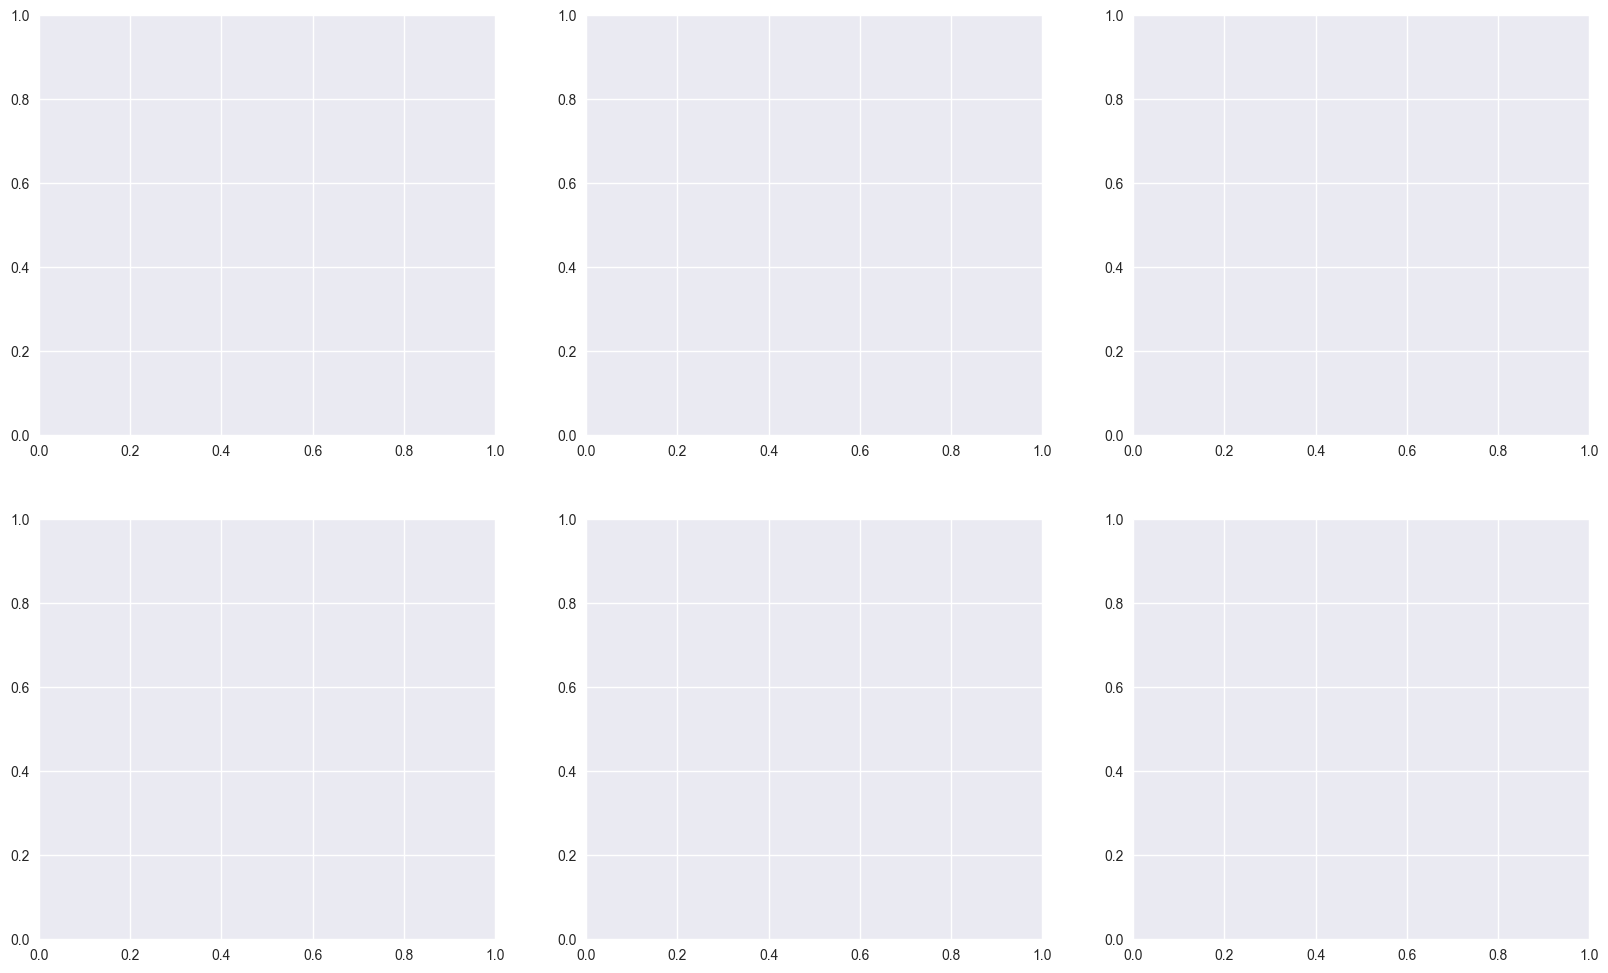

In [14]:
# Visualización mejorada de resultados con GridSearchCV
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# 1. Comparación de R² scores con barras de error
x_pos = np.arange(len(results_df))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, results_df['Train_R2'], width, 
                    label='Train R²', alpha=0.8, color='skyblue', capsize=5)
bars2 = axes[0].bar(x_pos + width/2, results_df['Test_R2'], width, 
                    yerr=results_df['CV_Std'], label='Test R²', alpha=0.8, 
                    color='orange', capsize=5)

axes[0].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Comparación R² Score: Train vs Test (con GridSearchCV)', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Añadir valores a las barras
for i, (train_val, test_val) in enumerate(zip(results_df['Train_R2'], results_df['Test_R2'])):
    axes[0].text(i - width/2, train_val + 0.01, f'{train_val:.3f}', ha='center', fontsize=8, fontweight='bold')
    axes[0].text(i + width/2, test_val + 0.01, f'{test_val:.3f}', ha='center', fontsize=8, fontweight='bold')

# 2. RMSE Comparison
bars3 = axes[1].bar(x_pos - width/2, results_df['Train_RMSE'], width, 
                    label='Train RMSE', alpha=0.8, color='lightgreen')
bars4 = axes[1].bar(x_pos + width/2, results_df['Test_RMSE'], width, 
                    label='Test RMSE', alpha=0.8, color='lightcoral')

axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Comparación RMSE: Train vs Test', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Test R² ranking con colores según performance
colors = ['green' if x > 0.8 else 'orange' if x > 0.7 else 'red' for x in results_df['Test_R2']]
bars5 = axes[2].barh(range(len(results_df)), results_df['Test_R2'], color=colors, alpha=0.7)

axes[2].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
axes[2].set_yticks(range(len(results_df)))
axes[2].set_yticklabels(results_df['Model'])
axes[2].set_xlabel('Test R² Score')
axes[2].set_title('Ranking de Modelos por Test R² (GridSearchCV)', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Añadir valores a las barras
for i, v in enumerate(results_df['Test_R2']):
    axes[2].text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=9)

# 4. Diferencia Train-Test (overfitting indicator)
diff_scores = results_df['Train_R2'] - results_df['Test_R2']
colors_diff = ['red' if x > 0.15 else 'orange' if x > 0.08 else 'green' for x in diff_scores]

bars6 = axes[3].bar(range(len(results_df)), diff_scores, color=colors_diff, alpha=0.7)
axes[3].axhline(y=0.15, color='red', linestyle='--', alpha=0.7, label='Overfitting Alto')
axes[3].axhline(y=0.08, color='orange', linestyle='--', alpha=0.7, label='Overfitting Moderado')
axes[3].set_xticks(range(len(results_df)))
axes[3].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[3].set_ylabel('Train R² - Test R²')
axes[3].set_title('Análisis de Overfitting (GridSearchCV)', fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# 5. Training Time vs Performance
if results_df['Training_Time'].sum() > 0:
    scatter = axes[4].scatter(results_df['Training_Time'], results_df['Test_R2'], 
                             c=results_df['Test_R2'], cmap='viridis', s=100, alpha=0.7)
    
    # Añadir línea de objetivo
    axes[4].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
    
    axes[4].set_xlabel('Training Time (seconds)')
    axes[4].set_ylabel('Test R²')
    axes[4].set_title('Eficiencia: Performance vs Tiempo de Entrenamiento', fontweight='bold')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    # Añadir etiquetas de modelos
    for i, model in enumerate(results_df['Model']):
        if results_df['Training_Time'].iloc[i] > 0:
            axes[4].annotate(model, (results_df['Training_Time'].iloc[i], results_df['Test_R2'].iloc[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
    
    # Colorbar
    plt.colorbar(scatter, ax=axes[4], label='Test R²')
else:
    axes[4].text(0.5, 0.5, 'No hay datos de tiempo\ndisponibles', ha='center', va='center', 
                transform=axes[4].transAxes, fontsize=12)
    axes[4].set_title('Training Time vs Performance', fontweight='bold')

# 6. Cross-Validation Stability
if len(results_df) > 0:
    # Crear gráfico de estabilidad de CV
    cv_mean = results_df['CV_R2']
    cv_std = results_df['CV_Std']
    
    bars7 = axes[5].bar(range(len(results_df)), cv_mean, yerr=cv_std, 
                        capsize=5, alpha=0.7, color='purple')
    axes[5].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
    axes[5].set_xticks(range(len(results_df)))
    axes[5].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[5].set_ylabel('Cross-Validation R²')
    axes[5].set_title('Estabilidad de Cross-Validation (5-fold)', fontweight='bold')
    axes[5].legend()
    axes[5].grid(True, alpha=0.3)
    
    # Añadir valores
    for i, (mean_val, std_val) in enumerate(zip(cv_mean, cv_std)):
        axes[5].text(i, mean_val + std_val + 0.01, f'{mean_val:.3f}±{std_val:.3f}', 
                    ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis estadístico adicional
print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS DE PERFORMANCE:")
print("-" * 50)

stats_summary = {
    'Métrica': ['Test R²', 'CV R²', 'Train-Test Gap', 'RMSE', 'MAE'],
    'Media': [
        results_df['Test_R2'].mean(),
        results_df['CV_R2'].mean(),
        (results_df['Train_R2'] - results_df['Test_R2']).mean(),
        results_df['Test_RMSE'].mean(),
        results_df['Test_MAE'].mean()
    ],
    'Mediana': [
        results_df['Test_R2'].median(),
        results_df['CV_R2'].median(),
        (results_df['Train_R2'] - results_df['Test_R2']).median(),
        results_df['Test_RMSE'].median(),
        results_df['Test_MAE'].median()
    ],
    'Mejor': [
        results_df['Test_R2'].max(),
        results_df['CV_R2'].max(),
        (results_df['Train_R2'] - results_df['Test_R2']).min(),
        results_df['Test_RMSE'].min(),
        results_df['Test_MAE'].min()
    ],
    'Peor': [
        results_df['Test_R2'].min(),
        results_df['CV_R2'].min(),
        (results_df['Train_R2'] - results_df['Test_R2']).max(),
        results_df['Test_RMSE'].max(),
        results_df['Test_MAE'].max()
    ]
}

stats_df = pd.DataFrame(stats_summary)
display(stats_df.round(4))

# Recomendaciones basadas en resultados
print(f"\n💡 RECOMENDACIONES BASADAS EN RESULTADOS:")
print("-" * 50)

best_r2 = results_df['Test_R2'].max()
models_above_08 = len(results_df[results_df['Test_R2'] > 0.8])

if models_above_08 > 0:
    print(f"✅ ¡Excelente! {models_above_08} modelo(s) superan el objetivo R² > 0.8")
    print(f"🏆 Mejor performance: {best_r2:.4f}")
    print(f"💭 Considerar ensemble de los mejores modelos para mayor robustez")
elif best_r2 > 0.75:
    print(f"🟡 Cerca del objetivo. Mejor R²: {best_r2:.4f}")
    print(f"💭 Sugerencias:")
    print(f"   - Probar feature engineering adicional")
    print(f"   - Aumentar rangos de hiperparámetros en GridSearch")
    print(f"   - Considerar ensemble methods")
else:
    print(f"🔴 Performance baja. Mejor R²: {best_r2:.4f}")
    print(f"💭 Acciones recomendadas:")
    print(f"   - Revisar calidad y relevancia de features")
    print(f"   - Analizar outliers y datos atípicos")
    print(f"   - Considerar transformaciones de target")
    print(f"   - Evaluar más modelos avanzados")

# Identificar modelos con mejor balance performance/tiempo
if results_df['Training_Time'].sum() > 0:
    efficiency_scores = results_df['Test_R2'] / np.log(results_df['Training_Time'] + 1)
    best_efficiency_idx = efficiency_scores.idxmax()
    best_efficiency_model = results_df.loc[best_efficiency_idx, 'Model']
    
    print(f"\n⚡ MODELO MÁS EFICIENTE: {best_efficiency_model}")
    print(f"   R²: {results_df.loc[best_efficiency_idx, 'Test_R2']:.4f}")
    print(f"   Tiempo: {results_df.loc[best_efficiency_idx, 'Training_Time']:.1f}s")

# Configuración de hiperparámetros para GridSearchCV
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.8, 1.0]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'cholesky']
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1.0],
        'selection': ['cyclic']
    },
    'Linear Regression': {
        'fit_intercept': [True, False]
    },
    'Decision Tree': {
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5],
        'criterion': ['squared_error']
    },
    'KNN': {
        'n_neighbors': [5, 7, 9],
        'weights': ['uniform', 'distance']
    }
}

print("Configuración de GridSearchCV completada")
print(f"Modelos configurados: {len(param_grids)}")

In [ ]:
# Entrenamiento con GridSearchCV
from sklearn.model_selection import GridSearchCV
import time

print("ENTRENAMIENTO DE MODELOS CON GRIDSEARCHCV")
print("=" * 50)

results = {}
best_models = {}
best_params = {}
training_times = {}

# Configurar GridSearchCV
cv_folds = 3
scoring_metric = 'r2'
n_jobs = -1

for name, config in models.items():
    print(f"\nEntrenando {name}...")
    
    # Determinar si usar datos escalados
    if config['scaled']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test
    
    base_model = config['model']
    param_grid = param_grids.get(name, {})
    
    if not param_grid:
        best_model = base_model
        best_model.fit(X_train_used, y_train)
        best_params[name] = "Parámetros por defecto"
        grid_search_time = 0
    else:
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=cv_folds,
            scoring=scoring_metric,
            n_jobs=n_jobs,
            verbose=0
        )
        
        start_time = time.time()
        grid_search.fit(X_train_used, y_train)
        grid_search_time = time.time() - start_time
        
        best_model = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_
        
        print(f"   GridSearch completado en {grid_search_time:.1f}s")
        print(f"   Mejor CV Score: {grid_search.best_score_:.4f}")
    
    training_times[name] = grid_search_time
    
    # Predicciones y métricas
    y_train_pred = best_model.predict(X_train_used)
    y_test_pred = best_model.predict(X_test_used)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    cv_scores = cross_val_score(best_model, X_train_used, y_train, 
                                cv=cv_folds, scoring=scoring_metric)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_test_pred': y_test_pred,
        'training_time': grid_search_time,
        'best_params': best_params[name]
    }
    
    best_models[name] = best_model
    
    print(f"   Test R²: {test_r2:.4f}")
    print(f"   CV R²: {cv_mean:.4f} ± {cv_std:.4f}")

print(f"\nEntrenamiento completado")

In [ ]:
# Comparación y visualización de resultados
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_R2': [results[model]['cv_mean'] for model in results.keys()],
    'CV_Std': [results[model]['cv_std'] for model in results.keys()],
    'Train_R2': [results[model]['train_r2'] for model in results.keys()],
    'Test_R2': [results[model]['test_r2'] for model in results.keys()],
    'Test_RMSE': [results[model]['test_rmse'] for model in results.keys()],
    'Test_MAE': [results[model]['test_mae'] for model in results.keys()]
})

results_df = results_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)

print("COMPARACIÓN DE RESULTADOS")
print("=" * 40)
display(results_df.round(4))

# Identificar mejor modelo
best_model_name = results_df.iloc[0]['Model']
best_test_r2 = results_df.iloc[0]['Test_R2']

print(f"\nMEJOR MODELO: {best_model_name}")
print(f"Test R²: {best_test_r2:.4f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Comparación R² scores
x_pos = np.arange(len(results_df))
width = 0.35

axes[0].bar(x_pos - width/2, results_df['Train_R2'], width, 
           label='Train R²', alpha=0.8, color='skyblue')
axes[0].bar(x_pos + width/2, results_df['Test_R2'], width, 
           label='Test R²', alpha=0.8, color='orange')

axes[0].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Comparación R² Score: Train vs Test')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test R² ranking
colors = ['green' if x > 0.8 else 'orange' if x > 0.7 else 'red' for x in results_df['Test_R2']]
axes[1].barh(range(len(results_df)), results_df['Test_R2'], color=colors, alpha=0.7)

axes[1].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
axes[1].set_yticks(range(len(results_df)))
axes[1].set_yticklabels(results_df['Model'])
axes[1].set_xlabel('Test R² Score')
axes[1].set_title('Ranking de Modelos por Test R²')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Validación Cruzada Detallada

In [ ]:
# Análisis del mejor modelo
best_model = best_models[best_model_name]
best_results = results[best_model_name]

print(f"ANÁLISIS DETALLADO: {best_model_name}")
print("=" * 50)

print(f"Mejores hiperparámetros:")
if isinstance(best_results['best_params'], dict):
    for param, value in best_results['best_params'].items():
        print(f"  {param}: {value}")
else:
    print(f"  {best_results['best_params']}")

print(f"\nMétricas de rendimiento:")
print(f"  Train R²: {best_results['train_r2']:.4f}")
print(f"  Test R²: {best_results['test_r2']:.4f}")
print(f"  CV R²: {best_results['cv_mean']:.4f} ± {best_results['cv_std']:.4f}")
print(f"  Test RMSE: {best_results['test_rmse']:.4f}")
print(f"  Test MAE: {best_results['test_mae']:.4f}")

# Feature importance si está disponible
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportancia de features:")
    for idx, row in feature_importance.iterrows():
        print(f"  {row['feature']:30s}: {row['importance']:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title(f'Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    feature_coef = pd.DataFrame({
        'feature': selected_features,
        'coefficient': abs(best_model.coef_)
    }).sort_values('coefficient', ascending=False)
    
    print(f"\nCoeficientes (valor absoluto):")
    for idx, row in feature_coef.iterrows():
        print(f"  {row['feature']:30s}: {row['coefficient']:.4f}")

# Visualización de predicciones vs valores reales
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: Predicciones vs Valores Reales
axes[0,0].scatter(y_test, best_results['y_test_pred'], alpha=0.6, color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valores Reales')
axes[0,0].set_ylabel('Predicciones')
axes[0,0].set_title(f'Predicciones vs Reales - {best_model_name}')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].text(0.05, 0.95, f'R² = {best_results["test_r2"]:.3f}', 
               transform=axes[0,0].transAxes, fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Residuos vs Predicciones
residuals = y_test - best_results['y_test_pred']
axes[0,1].scatter(best_results['y_test_pred'], residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0,1].set_xlabel('Predicciones')
axes[0,1].set_ylabel('Residuos')
axes[0,1].set_title('Residuos vs Predicciones')
axes[0,1].grid(True, alpha=0.3)

# 3. Distribución de residuos
axes[1,0].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'Media: {residuals.mean():.3f}')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Residuos')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Q-Q plot para normalidad de residuos
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot - Normalidad de Residuos')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nESTADÍSTICAS DE RESIDUOS:")
print(f"Media: {residuals.mean():.4f}")
print(f"Desviación estándar: {residuals.std():.4f}")
print(f"Mínimo: {residuals.min():.4f}")
print(f"Máximo: {residuals.max():.4f}")

GENERANDO CURVAS DE APRENDIZAJE - Gradient Boosting


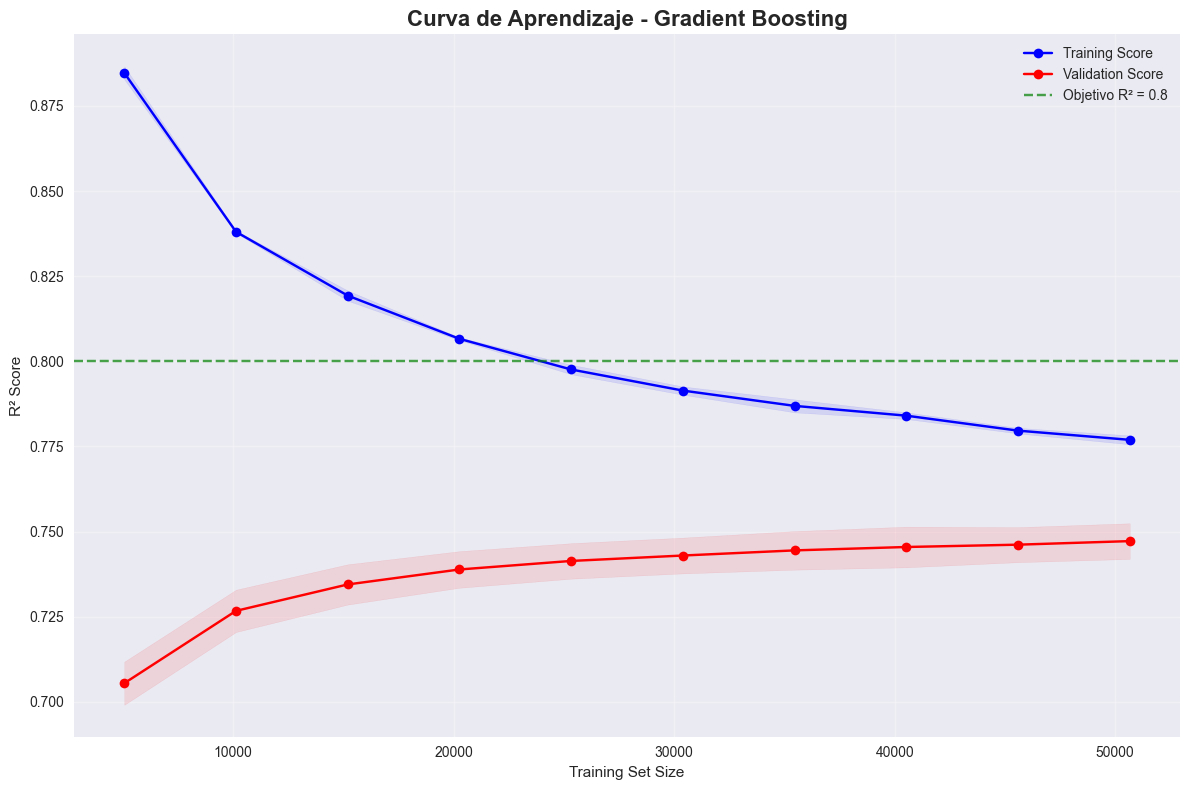


Rendimiento final:
Training Score (final): 0.7769 ± 0.0013
Validation Score (final): 0.7472 ± 0.0052
Gap Train-Val: 0.0297


In [160]:
# Curvas de aprendizaje para el mejor modelo
from sklearn.model_selection import learning_curve

print(f"GENERANDO CURVAS DE APRENDIZAJE - {best_model_name}")

# Seleccionar datos apropiados
if best_model_name in ['Ridge Regression', 'Support Vector Regression']:
    X_learning = X_train_scaled
else:
    X_learning = X_train

# Generar curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_learning, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='r2', n_jobs=-1
)

# Calcular medias y desviaciones
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Visualizar curva de aprendizaje
plt.figure(figsize=(12, 8))

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title(f'Curva de Aprendizaje - {best_model_name}', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Añadir líneas de referencia
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Objetivo R² = 0.8')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar estadísticas finales
print(f"\nRendimiento final:")
print(f"Training Score (final): {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"Validation Score (final): {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"Gap Train-Val: {abs(train_mean[-1] - val_mean[-1]):.4f}")

In [ ]:
# Validación cruzada detallada
from sklearn.model_selection import cross_validate

print(f"VALIDACIÓN CRUZADA DETALLADA - {best_model_name}")
print("=" * 50)

# Seleccionar datos apropiados según el modelo
if best_model_name in ['Ridge Regression', 'Lasso', 'ElasticNet', 'SVR', 'KNN', 'Linear Regression']:
    X_cv = X_train_scaled
else:
    X_cv = X_train

cv_results = cross_validate(
    best_model, X_cv, y_train, 
    cv=5, 
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'], 
    return_train_score=True
)

# Procesar resultados
metrics_summary = {
    'R²': {
        'train': cv_results['train_r2'],
        'test': cv_results['test_r2']
    },
    'RMSE': {
        'train': np.sqrt(-cv_results['train_neg_mean_squared_error']),
        'test': np.sqrt(-cv_results['test_neg_mean_squared_error'])
    },
    'MAE': {
        'train': -cv_results['train_neg_mean_absolute_error'],
        'test': -cv_results['test_neg_mean_absolute_error']
    }
}

# Mostrar estadísticas
for metric_name, metric_data in metrics_summary.items():
    train_scores = metric_data['train']
    test_scores = metric_data['test']
    
    print(f"\n{metric_name}:")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")

# Visualización de validación cruzada
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (metric_name, metric_data) in enumerate(metrics_summary.items()):
    train_scores = metric_data['train']
    test_scores = metric_data['test']
    
    x_pos = [1, 2]
    means = [train_scores.mean(), test_scores.mean()]
    stds = [train_scores.std(), test_scores.std()]
    
    axes[idx].bar(x_pos, means, yerr=stds, capsize=5, 
                  color=['skyblue', 'orange'], alpha=0.7)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(['Train', 'Test'])
    axes[idx].set_ylabel(metric_name)
    axes[idx].set_title(f'{metric_name} - Validación Cruzada')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Ensemble Methods para Mejorar R²

# Curvas de aprendizaje
from sklearn.model_selection import learning_curve

print(f"CURVAS DE APRENDIZAJE - {best_model_name}")

# Seleccionar datos apropiados
if best_model_name in ['Ridge Regression', 'Lasso', 'ElasticNet', 'SVR', 'KNN', 'Linear Regression']:
    X_learning = X_train_scaled
else:
    X_learning = X_train

# Generar curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_learning, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='r2', n_jobs=-1
)

# Calcular medias y desviaciones
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Visualizar curva de aprendizaje
plt.figure(figsize=(12, 8))

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.1, color='red')

plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Objetivo R² = 0.8')

plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title(f'Curva de Aprendizaje - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nRendimiento final:")
print(f"Training Score: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"Validation Score: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"Gap Train-Val: {abs(train_mean[-1] - val_mean[-1]):.4f}")

In [1]:
# 14. Guardar el Mejor Modelo para Producción

import pickle
import joblib
import os
import json

print("GUARDANDO MODELO DE REGRESIÓN PARA PRODUCCIÓN")
print("=" * 50)

# Crear directorio para modelos si no existe
model_dir = "../models/regression"
os.makedirs(model_dir, exist_ok=True)

# Obtener el mejor modelo y sus datos asociados
best_model_for_save = best_models[best_model_name]
best_params_for_save = results[best_model_name]['best_params']

# Determinar si usar datos escalados
scale_sensitive = ['Ridge Regression', 'Lasso', 'ElasticNet', 'SVR', 'KNN', 'Linear Regression']
use_scaler = best_model_name in scale_sensitive

# Preparar metadatos del modelo de regresión
model_metadata = {
    'model_name': best_model_name,
    'model_type': 'regression',
    'target': target,
    'features': selected_features,
    'use_scaler': use_scaler,
    'best_params': best_params_for_save,
    'performance_metrics': {
        'test_r2': results[best_model_name]['test_r2'],
        'test_rmse': results[best_model_name]['test_rmse'],
        'test_mae': results[best_model_name]['test_mae'],
        'cv_r2_mean': results[best_model_name]['cv_mean'],
        'cv_r2_std': results[best_model_name]['cv_std']
    },
    'target_info': {
        'min_value': float(y.min()),
        'max_value': float(y.max()),
        'mean_value': float(y.mean()),
        'std_value': float(y.std())
    },
    'feature_requirements': {
        feature: 'float64' for feature in selected_features
    }
}

# Guardar modelo principal
model_path = os.path.join(model_dir, "best_regression_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(best_model_for_save, f)

# Guardar scaler si se usa
scaler_used = None
if use_scaler:
    scaler_path = os.path.join(model_dir, "regression_scaler.pkl")
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    scaler_used = scaler_path
    print(f"Scaler guardado en: {scaler_path}")

# Guardar metadatos
metadata_path = os.path.join(model_dir, "regression_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"Modelo de regresión guardado exitosamente:")
print(f"   - Modelo: {model_path}")
print(f"   - Metadatos: {metadata_path}")
if use_scaler:
    print(f"   - Scaler: {scaler_path}")

print(f"\nInformación del modelo guardado:")
print(f"   - Tipo: {best_model_name}")
print(f"   - Target: {target}")
print(f"   - R² Score: {model_metadata['performance_metrics']['test_r2']:.4f}")
print(f"   - RMSE: {model_metadata['performance_metrics']['test_rmse']:.4f}")
print(f"   - Features: {len(selected_features)}")

# Verificar que el modelo se puede cargar correctamente
print(f"\nVerificando modelo de regresión guardado...")
try:
    # Cargar modelo
    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    
    # Cargar metadatos
    with open(metadata_path, 'r') as f:
        loaded_metadata = json.load(f)
    
    # Cargar scaler si existe
    loaded_scaler = None
    if use_scaler and scaler_used:
        with open(scaler_path, 'rb') as f:
            loaded_scaler = pickle.load(f)
    
    print(f"Todos los archivos se cargaron correctamente")
    
    # Probar predicción con datos de ejemplo
    test_sample = X_test.iloc[:1]
    if use_scaler and loaded_scaler:
        test_sample_scaled = loaded_scaler.transform(test_sample)
        test_pred = loaded_model.predict(test_sample_scaled)
    else:
        test_pred = loaded_model.predict(test_sample)
    
    actual_value = y_test.iloc[0]
    
    print(f"Predicción de prueba exitosa:")
    print(f"   - Valor real: {actual_value:.2f}")
    print(f"   - Predicción: {test_pred[0]:.2f}")
    print(f"   - Error absoluto: {abs(actual_value - test_pred[0]):.2f}")
    
except Exception as e:
    print(f"Error al verificar modelo: {str(e)}")

print(f"\nMODELO DE REGRESIÓN LISTO PARA PRODUCCIÓN")
print(f"=" * 50)

GUARDANDO MODELO DE REGRESIÓN PARA PRODUCCIÓN


NameError: name 'best_models' is not defined